# QSVM Scientific Paper: Quantum Kernel Estimation + Classical SVM = QSM

We try to reproduce the paper's second method: quantum kernel estimation with a diagonal Z-basis feature map interleaved with Hadamards, and a classical SVM trained on the quantum Gram matrix.

**Feature map (2 qubits):** for $x=(x_1,x_2)\in(0,2\pi]^2$,
- Single-qubit phases: $\phi_{\{1\}}(x)=x_1,\ \phi_{\{2\}}(x)=x_2$  
- Two-qubit phase: $\phi_{\{1,2\}}(x)=\big(\pi-x_1\big)\big(\pi-x_2\big)$  
- One layer: $H^{\otimes 2}\,\exp\!\big(i[\phi_{\{1\}} Z_1+\phi_{\{2\}}Z_2+\phi_{\{1,2\}}Z_1Z_2]\big)$  
- We use two such layers (H-diag-H-diag), matching the paper's construction.

**Kernel:** $k(x,z)=\big|\langle 0^{\otimes 2}\!\mid U^\dagger(z)\,U(x)\mid 0^{\otimes 2}\rangle\big|^2$  
We estimate it by the inverse-circuit overlap test (exact on a simulator in the paper they use quantum computer).

**Data (synthetic, as in the paper):**  
Labels are generated from $s(x)=\langle\Phi(x)\vert V^\dagger (Z\!\otimes\! Z)\,V\vert\Phi(x)\rangle$ with a fixed random two-qubit unitary $V$.  
Assign $y=+1$ if $s(x)\ge \Delta$, $y=-1$ if $s(x)\le -\Delta$, otherwise reject and resample (margin $\Delta=0.3$).  
We create 20 points per label for training and 20 per label for testing.


In [ ]:
pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.3/934.3 kB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 37.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 48.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

import pennylane as qml

np.set_printoptions(precision=4, suppress=True)
seed = 8
rng = np.random.default_rng(seed)


/usr/local/lib/python3.12/dist-packages/pennylane/__init__.py:209: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.6.2. You have version 0.7.2 installed. Please downgrade JAX to 0.6.2 to avoid runtime errors using python -m pip install jax~=0.6.0 jaxlib~=0.6.0
  warnings.warn(


## feature map $U_\Phi(x)$ (2-qubit, two layers)

One layer: $H^{\otimes 2}$ then a diagonal unitary  
$\exp\!\big(i[\phi_{\{1\}}(x) Z_1 + \phi_{\{2\}}(x) Z_2 + \phi_{\{1,2\}}(x) Z_1 Z_2]\big)$.

Implementation details (simulator):
- $e^{\,i\alpha Z} = R_Z(-2\alpha)$ up to a global phase (irrelevant for fidelity).
- $e^{\,i\beta Z\otimes Z} = \mathrm{IsingZZ}(-2\beta)$ up to a global phase.

We stack two such layers (H-diag-H-diag), as used in the paper's hardness discussion.


In [ ]:
n_qubits = 2
wires = list(range(n_qubits))
dev = qml.device("lightning.qubit", wires=n_qubits)  # exact statevector

def phi_single(x):
    # φ_{1}(x)=x1, φ_{2}(x)=x2
    return x[0], x[1]

def phi_pair(x):
    # φ_{1,2}(x) = (π - x1)(π - x2)
    return (np.pi - x[0]) * (np.pi - x[1])

def diag_layer(x):
    a1, a2 = phi_single(x)
    b = phi_pair(x)
    # exp(i a Z)  ~ RZ(-2a);  exp(i b Z⊗Z) ~ IsingZZ(-2b)
    qml.RZ(-2.0 * a1, wires=0)
    qml.RZ(-2.0 * a2, wires=1)
    qml.IsingZZ(-2.0 * b, wires=[0, 1])

def feature_map_havlicek(x):
    # Two layers: H–diag–H–diag
    qml.Hadamard(0); qml.Hadamard(1)
    diag_layer(x)
    qml.Hadamard(0); qml.Hadamard(1)
    diag_layer(x)

@qml.qnode(dev)
def overlap_prob(x, z):
    """Return Pr(|00>) after U(x) then U†(z): equals |<Φ(z)|Φ(x)>|^2."""
    feature_map_havlicek(x)
    qml.adjoint(feature_map_havlicek)(z)
    return qml.probs(wires=wires)

def kernel_entry(x, z):
    return float(overlap_prob(x, z)[0])

def kernel_matrix(XA, XB):
    return np.array([[kernel_entry(a, b) for b in XB] for a in XA], dtype=float)


## Synthetic data with a margin (as in the paper)

Define labels using a hidden random two-qubit unitary $V$ and the parity observable $f=Z\otimes Z$:
$$
s(x)=\langle\Phi(x)\vert V^\dagger (Z\otimes Z)\,V\vert\Phi(x)\rangle\in[-1,1].
$$
With margin $\Delta=0.3$,
$$
y(x)=\begin{cases}
+1 & \text{if } s(x)\ge \Delta,\\
-1 & \text{if } s(x)\le -\Delta,\\
\text{reject} & \text{otherwise (resample)}.
\end{cases}
$$
We sample $x\sim\mathrm{Unif}\big((0,2\pi]^2\big)$ until we get the desired counts.


In [ ]:
# Build a random-ish two-qubit unitary V via a short hardware-efficient pattern
def apply_random_unitary(params):
    # One entangling layer with local random rotations
    (a0,b0,c0, a1,b1,c1, theta) = params
    # local on qubit 0
    qml.RZ(a0, wires=0); qml.RX(b0, wires=0); qml.RZ(c0, wires=0)
    # local on qubit 1
    qml.RZ(a1, wires=1); qml.RX(b1, wires=1); qml.RZ(c1, wires=1)
    # simple ZZ-type entangler
    qml.IsingXX(theta, wires=[0,1])
    qml.IsingZZ(theta/2, wires=[0,1])

V_params = rng.uniform(0, 2*np.pi, size=7)

dev_v = qml.device("lightning.qubit", wires=n_qubits)

@qml.qnode(dev_v)
def s_of_x(x):
    feature_map_havlicek(x)
    apply_random_unitary(V_params)     # apply V
    return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1))  # measure Z⊗Z

def sample_dataset(n_per_label=20, Delta=0.3, max_tries=100000):
    Xp, yp = [], []
    tries = 0
    while (yp.count(+1) < n_per_label or yp.count(-1) < n_per_label) and tries < max_tries:
        tries += 1
        x = rng.uniform(low=1e-6, high=2*np.pi, size=2)
        val = s_of_x(x)
        if val >= Delta and yp.count(+1) < n_per_label:
            Xp.append(x); yp.append(+1)
        elif val <= -Delta and yp.count(-1) < n_per_label:
            Xp.append(x); yp.append(-1)
    if yp.count(+1) < n_per_label or yp.count(-1) < n_per_label:
        raise RuntimeError("Could not assemble margin-separated dataset; try lowering Δ or increasing max_tries.")
    return np.array(Xp), np.array(yp, dtype=int)

# Build train and test sets (20 per label each), with a fresh random set of inputs for test
X_train, y_train = sample_dataset(n_per_label=20, Delta=0.3)
X_test,  y_test  = sample_dataset(n_per_label=20, Delta=0.3)
print("Train:", X_train.shape, np.unique(y_train, return_counts=True))
print("Test :", X_test.shape,  np.unique(y_test,  return_counts=True))


Train: (40, 2) (array([-1,  1]), array([20, 20]))
Test : (40, 2) (array([-1,  1]), array([20, 20]))


## Quantum kernel estimation → classical SVM

- Compute Gram matrix $K_{\text{train}}[i,j]=k(x_i,x_j)$ with the inverse-circuit.
- Train SVM with `kernel='precomputed'`.
- For test inputs $z$, build $K_{\text{test}}[j,i]=k(z_j,x_i)$ against the training points.


QSVM test accuracy: 1.0000


<Figure size 400x300 with 0 Axes>

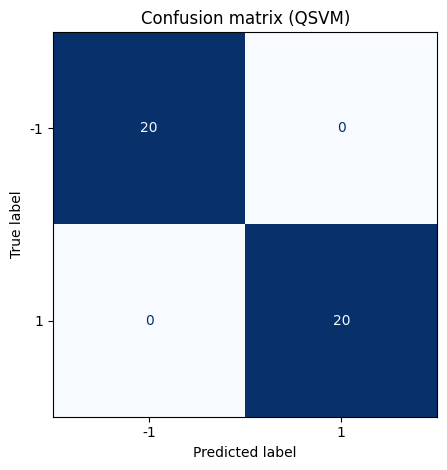

In [ ]:
# Build Gram matrices
K_train = kernel_matrix(X_train, X_train)
K_test  = kernel_matrix(X_test,  X_train)

# Train a standard SVM on the quantum kernel
clf = SVC(kernel='precomputed', C=1.0)  # C can be tuned; paper uses standard SVM on the kernel
clf.fit(K_train, y_train)

# Predict with precomputed K_test
y_pred = clf.predict(K_test)
acc = accuracy_score(y_test, y_pred)
print(f"QSVM test accuracy: {acc:.4f}")

# Confusion matrix
labels = np.unique(y_test)
cm = confusion_matrix(y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
plt.figure(figsize=(4,3))
disp.plot(values_format='d', cmap='Blues', colorbar=False)
plt.title("Confusion matrix (QSVM)")
plt.tight_layout()
plt.show()


## Quick kernel sanity checks

- Heatmap of $K_{\text{train}}$ (bright diagonal, structured off-diagonals).
- Histogram of off-diagonal similarities (upper triangle).


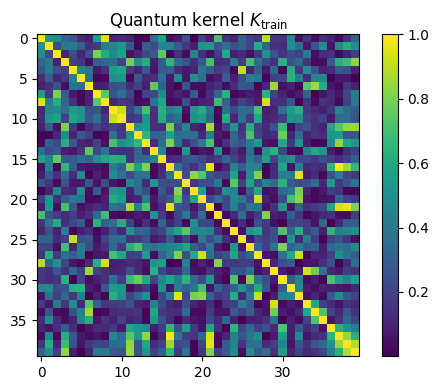

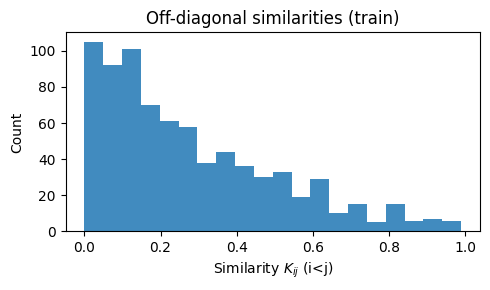

In [ ]:
plt.figure(figsize=(5,4))
plt.imshow(K_train, cmap="viridis")
plt.colorbar(); plt.title("Quantum kernel $K_{\\text{train}}$")
plt.tight_layout(); plt.show()

# Off-diagonal histogram
n = len(y_train)
tri = np.triu_indices(n, k=1)
vals = K_train[tri]
plt.figure(figsize=(5,3))
plt.hist(vals, bins=20, alpha=0.85)
plt.xlabel("Similarity $K_{ij}$ (i<j)")
plt.ylabel("Count"); plt.title("Off-diagonal similarities (train)")
plt.tight_layout(); plt.show()


## Notes

- This notebook uses an exact simulator (`lightning.qubit`), so kernel entries are noiseless. The paper used finite shots and error mitigation.
- The feature map matches the paper's diagonal-in-Z with Hadamards (two layers). Depth and parameterization matter for hardness; the two-layer construction is the one highlighted in the paper.
- The data generator here follows the paper's procedure: labels from $V^\dagger (Z\otimes Z) V$ with a margin $\Delta$, ensuring clean separability for a fair QSVM test.

## QSVM with finite shots (sampling)

We estimate the quantum kernel via the inverse-circuit overlap with shots:
$$
k(x,z)=\Pr(00\ldots 0\mid U^\dagger(z)U(x)\lvert 0\ldots 0\rangle)
$$
On a shot-based device, `qml.probs` returns empirical frequencies. Larger `SHOTS` → lower standard error $\approx \sqrt{p(1-p)/\text{SHOTS}}$, largest near $p=0.5$.

Below:
1) Shot-based kernel estimator (exact same feature map).  
2) (Optional) diagonal renormalization to force \(K_{ii}=1\).  
3) Train SVM on precomputed shot kernels; evaluate + confusion matrix.  
4) (Optional) average multiple shot batches to reduce variance.


In [ ]:
import numpy as np
import pennylane as qml

# --- configure your shot budget ---
SHOTS = 8192  # try 4096–16384

def make_overlap_qnode(feature_map, n_wires, shots=SHOTS, device_name="default.qubit"):
    """
    Returns a QNode overlap(x, z) that measures probs with finite shots.
    `feature_map(x)` must use the same wire indices (0..n_wires-1).
    """
    dev = qml.device(device_name, wires=n_wires, shots=shots)
    @qml.qnode(dev)
    def overlap(x, z):
        feature_map(x)
        qml.adjoint(feature_map)(z)
        return qml.probs(wires=range(n_wires))  # empirical frequencies
    return overlap

def kernel_matrix_shots(XA, XB, overlap_fn, symmetric=False):
    """
    Build Gram matrix with finite shots using an overlap QNode.
    If symmetric=True and XA is XB, fills both triangles.
    """
    A, B = len(XA), len(XB)
    K = np.empty((A, B), dtype=float)
    if symmetric and A == B:
        for i in range(A):
            K[i, i] = float(overlap_fn(XA[i], XB[i])[0])
            for j in range(i+1, B):
                val = float(overlap_fn(XA[i], XB[j])[0])
                K[i, j] = val
                K[j, i] = val
    else:
        for i in range(A):
            for j in range(B):
                K[i, j] = float(overlap_fn(XA[i], XB[j])[0])
    return K

def renormalize_diagonal(K):
    """Optional: enforce K_ii = 1 → K_ij / sqrt(K_ii K_jj) (useful when shots/noise deflate the diagonal)."""
    d = np.sqrt(np.clip(np.diag(K), 1e-12, None))
    Dinv = 1.0 / d
    return (K * Dinv[:, None]) * Dinv[None, :]


In [ ]:
# def feature_map_havlicek(x): ...  # prepares a 2-qubit state on wires 0,1

# Build the shot-based overlap for 2 wires
overlap_hav = make_overlap_qnode(feature_map_havlicek, n_wires=2, shots=SHOTS)

# Compute Gram matrices (train/train and test/train)
K_train_shots = kernel_matrix_shots(X_train, X_train, overlap_hav, symmetric=True)
K_test_shots  = kernel_matrix_shots(X_test,  X_train, overlap_hav, symmetric=False)

# Optional: renormalize the diagonal to exactly 1
RENORM = False
if RENORM:
    K_train_shots = renormalize_diagonal(K_train_shots)
    K_test_shots  = renormalize_diagonal(K_test_shots)

print("K_train_shots shape:", K_train_shots.shape, "diag (mean):", np.mean(np.diag(K_train_shots)))
print("K_test_shots  shape:", K_test_shots.shape)


/usr/local/lib/python3.12/dist-packages/pennylane/devices/device_api.py:193: PennyLaneDeprecationWarning: Setting shots on device is deprecated. Please use the `set_shots` transform on the respective QNode instead.
  warnings.warn(


K_train_shots shape: (40, 40) diag (mean): 1.0
K_test_shots  shape: (40, 40)


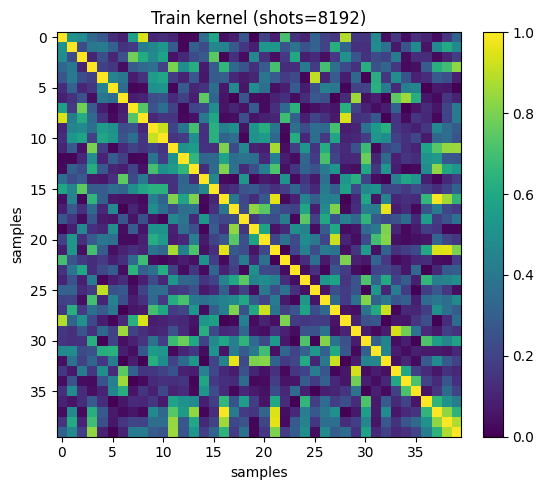

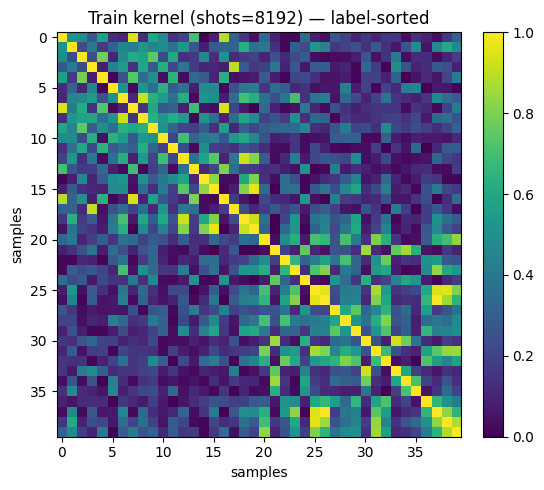

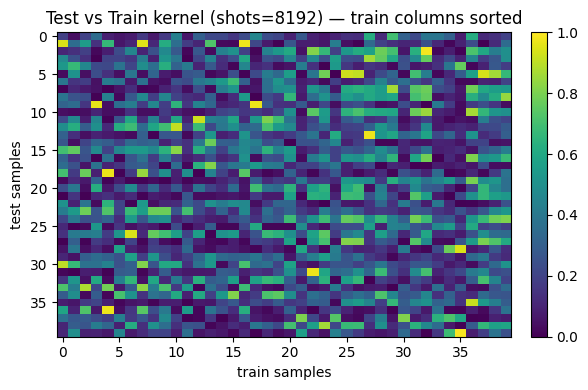

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_kernel_square(K, y=None, sort=False, title="Gram matrix"):
    """
    Plot a square Gram matrix (e.g., K_train_shots).
    If sort=True and y is provided, reorder by label for clearer blocks.
    """
    if sort and y is not None:
        idx = np.argsort(y)
        Kp = K[np.ix_(idx, idx)]
    else:
        Kp = K

    plt.figure(figsize=(6,5))
    im = plt.imshow(Kp, vmin=0, vmax=1, aspect='equal', cmap='viridis')
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.title(title)
    plt.xlabel("samples")
    plt.ylabel("samples")
    plt.tight_layout()
    plt.show()

def plot_kernel_rect(K, y_cols=None, sort_cols=False, title="Test vs Train Gram"):
    """
    Plot a rectangular Gram matrix (e.g., K_test_shots of shape [n_test, n_train]).
    If sort_cols=True and y_cols is provided, reorder **columns** by train labels.
    """
    if sort_cols and y_cols is not None:
        jdx = np.argsort(y_cols)
        Kp = K[:, jdx]
    else:
        Kp = K

    plt.figure(figsize=(6,4))
    im = plt.imshow(Kp, vmin=0, vmax=1, aspect='auto', cmap='viridis')
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.title(title)
    plt.xlabel("train samples")
    plt.ylabel("test samples")
    plt.tight_layout()
    plt.show()

# --- Example calls (assuming you already have K_train_shots, K_test_shots, y_train) ---

# Unsorted train kernel
plot_kernel_square(K_train_shots, y=y_train, sort=False,
                   title=f"Train kernel (shots={SHOTS})")

# Label-sorted train kernel (clearer class blocks)
plot_kernel_square(K_train_shots, y=y_train, sort=True,
                   title=f"Train kernel (shots={SHOTS}) — label-sorted")

# Test-vs-train kernel, columns sorted by train labels
plot_kernel_rect(K_test_shots, y_cols=y_train, sort_cols=True,
                 title=f"Test vs Train kernel (shots={SHOTS}) — train columns sorted")
